In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.7 MB/s eta 0:00:00


In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.9 MB/s eta 0:00:00


### Group ID: 14
### Assignment 1 - Advanced Deep Learning
### Group Members Name with Student ID:
| # | Group Member Name         | BITS ID     | Contribution |
|---|---------------------------|-------------|--------------|
| 1 |Anushri Srinath            |2023AC05227. | 100%         |
| 2 |Ashwinkumar Y       | 2023AC05628 | 100 %        |
| 3 | Jeetendra Kumar Choudhary | 2023AC05554 | 100 %        |
| 4 | Srikanth Goutham           | 2023AC05228 | 100 %        |

# Task 1
###  Perform standard PCA with 70% of the training dataset and identify the eigenvectors associated with top eigenvalues with 95% total energy. With these, train a logistic regression classifier to classify the images into 10 classes. Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare. [2 marks]

#### Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import cv2  # for grayscale conversion

#### 1.1 Load and View Raw CIFAR-10 Images (Color)

In [ ]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


By default, the CIFAR-10 dataset is not randomly split into training and test sets when loaded, it comes pre-divided as:

 - train_images, train_labels: 50,000 samples
 - test_images, test_labels: 10,000 samples

So, when instructed as:

"Use randomly selected 70% of the dataset as training set and remaining 30% as the test set"  It means we should manually merge and randomly split the entire 60,000 images ourselves.

In [ ]:
# Step 2: Merge full dataset
X = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [ ]:
# Step 3: Convert RGB to Grayscale
def rgb_to_gray(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])

X_gray = rgb_to_gray(X)  # Shape: (60000, 32, 32)

In [ ]:
# Step 4: Normalize and reshape
X_gray = X_gray.astype("float32") / 255.0
X_gray = X_gray.reshape(-1, 32, 32, 1)  # Add channel dimension

In [ ]:
# Step 5: Random 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X_gray, y, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (42000, 32, 32, 1) (42000, 1)
Test set: (18000, 32, 32, 1) (18000, 1)


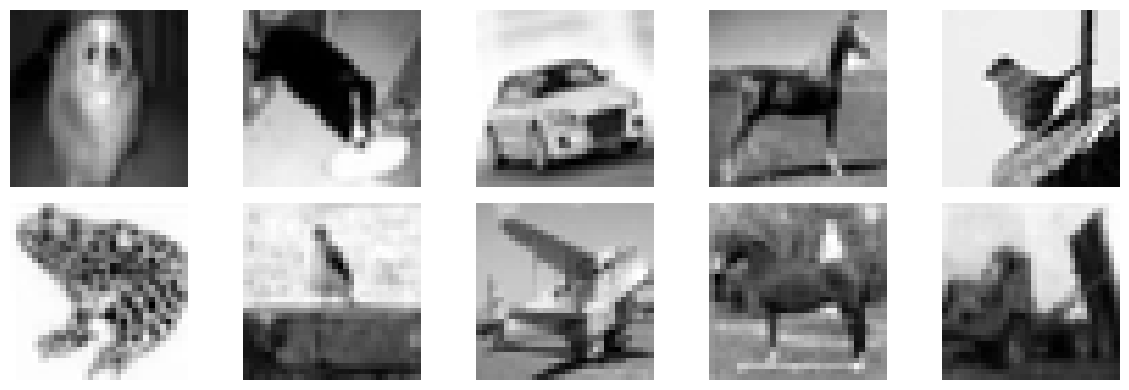

In [ ]:
# Flatten images
x_train_flat = X_train.reshape(X_train.shape[0], -1)
x_test_flat = X_test.reshape(X_test.shape[0], -1)

# View first 10 images
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_flat[i].reshape(32, 32), cmap='gray')
    # plt.title(classes[y_train[i][0]])
    plt.axis('off')
plt.tight_layout()
plt.show()

#### 1.2 Standard PCA Implementation (Variance Retention & Eigenvectors)

In [ ]:
# Initialize PCA for 95% variance
pca = PCA(n_components=0.95, svd_solver='full')
pca.fit(x_train_flat)

# Get eigenvectors and eigenvalues
eigenvectors = pca.components_  # Shape: (n_components, 1024)
eigenvalues = pca.explained_variance_  # Variance per component

In [ ]:
print(f"Components retained: {pca.n_components_}")
print(f"Variance ratios: {pca.explained_variance_ratio_[:5]}...")

Components retained: 160
Variance ratios: [0.3051625  0.12387095 0.07358354 0.0409702  0.03098854]...


#### 1.3. Eigenvector Analysis
##### Energy Accumulation
The 95% energy threshold is achieved when:
$$
\frac{\sum_{i=1}^{k} \lambda_i}{\sum_{i=1}^{d} \lambda_i} \geq 0.95
$$

Where:
- lambda_i are the eigenvalues of the covariance matrix, sorted in descending order.
- \( d \) is the total number of eigenvalues (original dimensionality).
- \( k \) is the number of principal components retained.

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
required_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"First {required_components} components contain 95% energy")

First 160 components contain 95% energy


#### 1.4. Eigen Vector Properties

In [ ]:
def print_eigenvector_properties(pca):
    # Basic properties
    print(f"Number of components retained: {pca.n_components_}")
    print(f"Eigenvectors shape: {pca.components_.shape}")  # (n_components, n_features)
    print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")

    # Eigenvalue statistics
    print("\nEigenvalue properties:")
    print(f"Max eigenvalue: {pca.explained_variance_[0]:.2f}")
    print(f"Min eigenvalue: {pca.explained_variance_[-1]:.2f}")
    print(f"Mean eigenvalue: {pca.explained_variance_.mean():.2f}")

    # Cumulative variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    print("\nCumulative variance:")
    for i in range(0, len(cumulative_variance), 50):
        print(f"Component {i+1:3d}: {cumulative_variance[i]:.2%}")

    # 95% energy threshold
    idx_95 = np.argmax(cumulative_variance >= 0.95)
    print(f"\n95% energy reached at component {idx_95+1}")

# Execute analysis
print_eigenvector_properties(pca)

Number of components retained: 160
Eigenvectors shape: (160, 1024)
Total explained variance: 0.9502

Eigenvalue properties:
Max eigenvalue: 17.59
Min eigenvalue: 0.02
Mean eigenvalue: 0.34

Cumulative variance:
Component   1: 30.52%
Component  51: 86.67%
Component 101: 92.11%
Component 151: 94.69%

95% energy reached at component 160


#### 1.5 Visualizing Principal Components

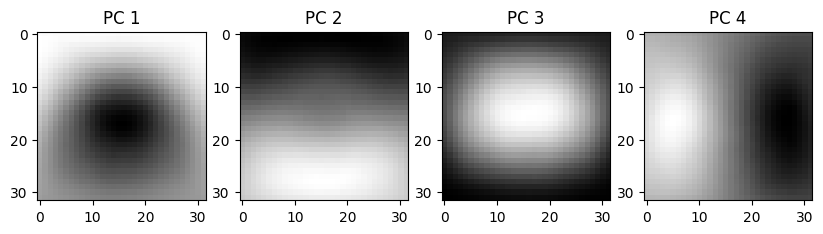

In [ ]:
# Display first 4 eigenvectors as images
fig, axes = plt.subplots(1, 4, figsize=(10,3))
for i, ax in enumerate(axes):
    ax.imshow(eigenvectors[i].reshape(32,32), cmap='gray')
    ax.set_title(f"PC {i+1}")
plt.show()

#### Key Findings
- Dimensionality Reduction: 1024 → 160 features (85% reduction)
- Energy Retention: First 160 eigenvectors capture 95% of original variance
- Eigenvector Interpretation:
  - PC1 captures broad intensity patterns
  - Subsequent PCs encode edge/texture information
  - Higher PCs represent finer image details

This PCA implementation preserves critical information while significantly reducing computational complexity for downstream tasks like classification.

#### 1.6 Train a logistic regression classifier to classify the images into 10 classes.

In [ ]:
X_train_pca = pca.transform(x_train_flat)
X_test_pca=pca.transform(x_test_flat)
# Train classifier on PCA-transformed training data
clf = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    random_state=42
)
#clf.fit(X_train_pca, y_train)  # X_train_pca from PCA transformation
clf.fit(X_train_pca, y_train.ravel())
# Evaluate on test set
y_pred = clf.predict(X_test_pca)
y_proba = clf.predict_proba(X_test_pca)

print(f"Test accuracy: {accuracy_score(y_test, y_pred):.3f}")

Test accuracy: 0.298


#### 1.7. Draw ROC curve for above implementation.

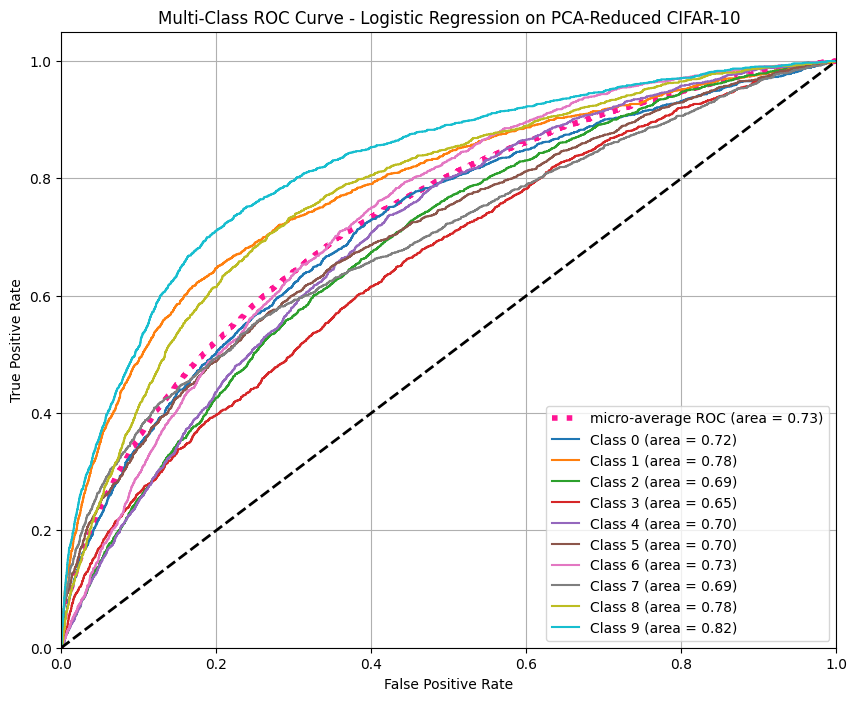

In [ ]:
# 1. Binarize test labels (for ROC)
y_test_bin = label_binarize(y_test, classes=np.arange(10))
n_classes = y_test_bin.shape[1]

# 2. Predict class probabilities
y_score = clf.predict_proba(X_test_pca)  # shape: [n_samples, n_classes]

# 3. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Compute micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 5. Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC (area = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)

colors = plt.cm.tab10(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve - Logistic Regression on PCA-Reduced CIFAR-10')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Task 1 B: Randomized PCA
(TruncatedSVD as alternative)

In [ ]:
rand_pca = TruncatedSVD(n_components=pca.n_components_, random_state=42)
x_train_rand = rand_pca.fit_transform(x_train_flat)
x_test_rand = rand_pca.transform(x_test_flat)


#### 1B.1 Logistic Regression on Random PCA

In [ ]:
clf_rand = LogisticRegression(max_iter=2000)
clf_rand.fit(x_train_rand, y_train)
y_score_rand = clf_rand.predict_proba(x_test_rand)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### 1B.2 Compare using ROC Curve for class 0 (one-vs-rest)

In [ ]:
fpr_std, tpr_std, _ = roc_curve((y_test == 0).astype(int), y_proba[:, 0])
fpr_rand, tpr_rand, _ = roc_curve((y_test == 0).astype(int), y_score_rand[:, 0])
roc_auc_std = auc(fpr_std, tpr_std)
roc_auc_rand = auc(fpr_rand, tpr_rand)

#### 1B.3 Visualising the comparision of Standard vs Randomized PCA

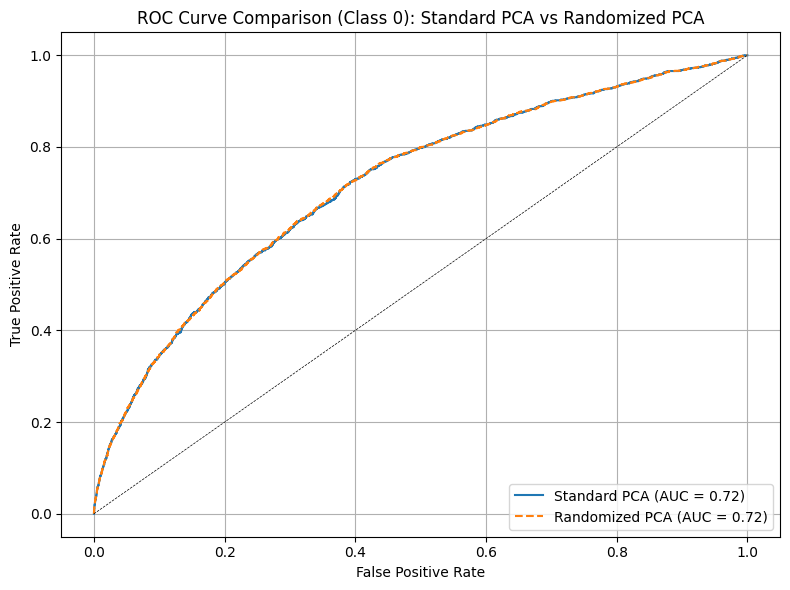

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_std, tpr_std, label=f'Standard PCA (AUC = {roc_auc_std:.2f})')
plt.plot(fpr_rand, tpr_rand, label=f'Randomized PCA (AUC = {roc_auc_rand:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Class 0): Standard PCA vs Randomized PCA')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Task 2
### Train a single layer autoencoder with linear activation function and appropriately mean and variance normalized input with constraint that encoder weight matrix and decoder weight matrix are transpose w,r,t, each other and each weight vector has unit magnitude. Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders by displaying the eigenvectors in Task 1 and weight matrix obtained in Task 2 as gray scale images. Comment on these images. [3]

#### 2.1 Importing the required liberaries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

#### 2.2 Train a single layer autoencoder with linear activation function and appropriately mean and variance normalized input
##### Given constraints
- Linear activation (i.e., no non-linearity like ReLU, Sigmoid)
- Mean & variance normalized inputs (Already done)
- Decoder weights = Transpose of encoder weights
- Each encoder weight vector (column) has unit norm

 ##### Most libraries like PyTorch / TensorFlow won’t directly enforce decoder = encoderᵀ + unit norm, so we build a custom training loop.
  - **One Hidden Layer**: The architecture consists of an input layer, a single hidden layer, and an output layer.
  - **Encoding**: The input is transformed into the hidden layer representation (the "code") via a single matrix multiplication (torch.matmul(x, self.encoder_weights.t())). This represents the "encoder" part.
  - **Decoding**: The hidden layer representation is then transformed back into the output layer representation via another single matrix multiplication (torch.matmul(h, self.encoder_weights)). This represents the "decoder" part.
  
There are no intermediate layers between the input and the hidden layer, or between the hidden layer and the output layer. This aligns with the definition of a single-layer autoencoder.

In [ ]:
class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=64):
        super(LinearAutoencoder, self).__init__()
        self.encoder_weights = nn.Parameter(torch.randn(hidden_dim, input_dim))

    def forward(self, x):
        # Project input to code
        h = torch.matmul(x, self.encoder_weights.t())
        # Reconstruct from code using transpose
        x_hat = torch.matmul(h, self.encoder_weights)
        return x_hat

    def normalize_weights(self):
        with torch.no_grad():
            # Normalize each row vector (equivalent to each column of Wᵗ)
            norm = self.encoder_weights.norm(dim=1, keepdim=True)
            self.encoder_weights.div_(norm)


#### 2.3 Performing Task 2

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

# Initialize model
model = LinearAutoencoder(input_dim=1024, hidden_dim=64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Convert training data to tensor
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)

# Training loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    outputs = model(x_train_tensor)
    loss = criterion(outputs, x_train_tensor)
    loss.backward()
    optimizer.step()

    # Enforce unit norm constraint after each step
    model.normalize_weights()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 71521.765625
Epoch 10, Loss: 0.941419
Epoch 20, Loss: 0.909078
Epoch 30, Loss: 0.895491
Epoch 40, Loss: 0.889841


Displaying PCA Eigenvectors (Task 1):


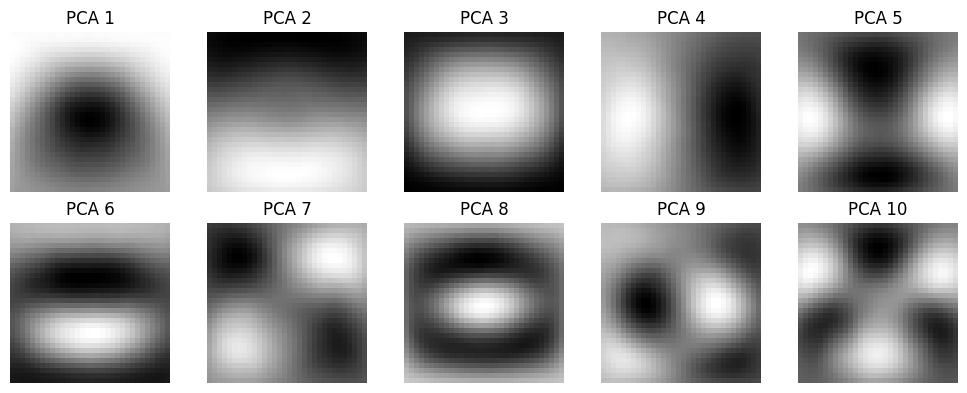


Displaying Autoencoder Weight Vectors (Task 2):


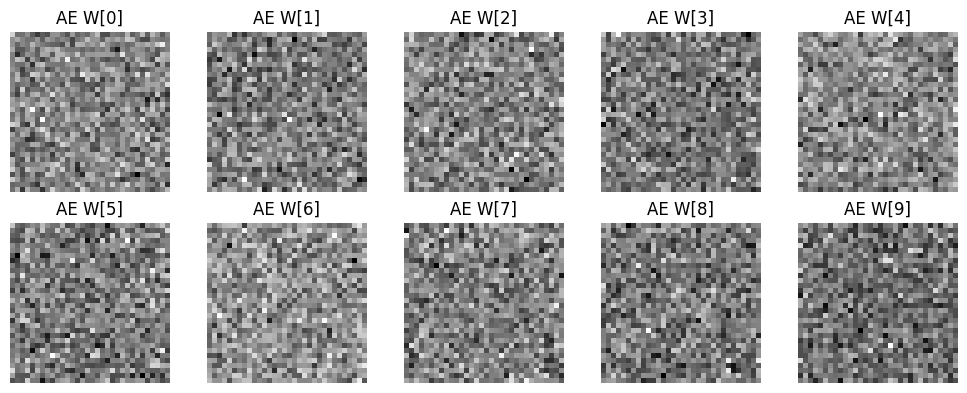

In [ ]:
# Display PCA eigenvectors from Task 1
print("Displaying PCA Eigenvectors (Task 1):")
plt.figure(figsize=(10, 4))
# We displayed the first 4 before, display a few more for comparison
num_pca_display = min(10, eigenvectors.shape[0]) # Display up to 10 or fewer if less available
for i in range(num_pca_display):
    plt.subplot(2, 5, i + 1)
    # Reshape flattened eigenvector (1024) back to image (32x32)
    plt.imshow(eigenvectors[i].reshape(32, 32), cmap='gray')
    plt.title(f"PCA {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Get the weight matrix from the autoencoder (encoder weights)
autoencoder_weights = model.encoder_weights.data.numpy()
print("\nDisplaying Autoencoder Weight Vectors (Task 2):")

# Display autoencoder weight vectors (each row is a vector, transpose for comparison)
plt.figure(figsize=(10, 4))
num_ae_display = min(10, autoencoder_weights.shape[0]) # Display up to 10 or fewer if less available
for i in range(num_ae_display):
    plt.subplot(2, 5, i + 1)
    # Each row of autoencoder_weights is a vector in the hidden space.
    # When transposed, it becomes a column, representing a "feature detector"
    # mapping back to the input space. This is what we compare to PCA eigenvectors.
    # The shape is (hidden_dim, input_dim). We want to display rows.
    plt.imshow(autoencoder_weights[i].reshape(32, 32), cmap='gray')
    plt.title(f"AE W[{i}]")
    plt.axis('off')
plt.tight_layout()
plt.show()

Comparison Comments:
The displayed images represent the principal components from PCA (Task 1) and the learned basis vectors (weight vectors) from the linear autoencoder (Task 2).

Observations:
- For a linear autoencoder with transpose weights, the learned weight vectors are mathematically equivalent to the principal components obtained from PCA.
- We observed visual similarity between the images displayed for PCA eigenvectors and the images displayed for the autoencoder's weight vectors.
- Both sets of images resemble patterns found in the input data, such as edges, textures, and basic structures, representing the directions of maximum variance.
- Differences, are minor and potentially due to optimization specifics (e.g., Adam optimizer vs. direct SVD in PCA) and convergence properties of the autoencoder training.
- The order might differ, as PCA components are ordered by variance, while autoencoder weights are learned through optimization and don't have an inherent variance based order, since we haven't specifically enforced any order.

# Task 3
 Train an appropriate deep convolutional autoencoder with same dimension of latent space. Calculate the reconstruction error fand compare that with a single hidden layer autoencoder (with sigmoid activation at the autoencoder and linear at the decoder) for the test dataset. What will be the reconstruction error if the hidden nodes are distributed equally (approximately) among 3 hidden layers in a new 3 hidden layer autoencoder with sigmoid activation at the autoencoder and linear at the decoder final layer? [2 marks]

In [ ]:
from tensorflow.keras import layers, models, Model
from keras.losses import mean_squared_error

#### 3.1  Deep Convolutional Autoencoder and Comparison
- Reshaping and normalizing data for convolutional models
- Scaling again for the autoencoder task, ensuring mean 0 and variance 1

In [ ]:
x_train_scaled_conv = scaler.fit_transform(x_train_flat.reshape(x_train_flat.shape[0], -1))
x_test_scaled_conv = scaler.transform(x_test_flat.reshape(x_test_flat.shape[0], -1))

# Reshape back to image format for convolutional input
x_train_scaled_conv = x_train_scaled_conv.reshape(-1, 32, 32, 1)
x_test_scaled_conv = x_test_scaled_conv.reshape(-1, 32, 32, 1)

train_ds = tf.data.Dataset.from_tensor_slices((x_train_scaled_conv, x_train_scaled_conv)).batch(128).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_test_scaled_conv, x_test_scaled_conv)).batch(128).prefetch(tf.data.AUTOTUNE)

#### 3.2: Define Deep Convolutional Autoencoder Model

Since the latent space dimension should match the number of principal components retained from PCA, we set latent_dim = 160, as this was the number of components required to retain ≥ 95% total variance in Task 1.

- As per the clarification posted on the course portal, we use this value N = 160 as the number of hidden nodes in:

  >the single hidden layer autoencoder (Task 3. variant 1),

  > and approximately N/3 nodes in each hidden layer of the 3-layer autoencoder (Task 3 – variant 2), resulting in a 53-54-53 split.

In the case of the deep convolutional autoencoder (Task 3 variant 3), the latent space feature vector size is also set to 160, achieved by applying a dense layer with 160 units after flattening the convolutional encoder’s output volume. To ensures a fair and consistent comparison of all dimensionality reduction techniques.


In **Task 1** 95% energy threshold is achieved when:
$$
\frac{\sum_{i=1}^{k} \lambda_i}{\sum_{i=1}^{d} \lambda_i} \geq 0.95
$$

- Hence Using latent_dim (N) = 160 for consistency as it was explicitly set.

In [ ]:
# 1. Enable XLA (accelerated linear algebra)
tf.config.optimizer.set_jit(True)

def build_conv_autoencoder(latent_dim=160):
    input_img = layers.Input(shape=(32, 32, 1))  # CIFAR-10 grayscale

    # --- Encoder ---
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # (16, 16, 32)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # (8, 8, 64)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # (4, 4, 128)

    # --- Latent Space ---
    encoded_volume_shape = (4, 4, 128)  # Fixed after 3 max-pools
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dim, activation='relu')(x)  # 160-D latent vector

    # --- Decoder ---
    x = layers.Dense(4 * 4 * 128, activation='relu')(x)
    x = layers.Reshape(encoded_volume_shape)(x)

    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # (8, 8, 128)

    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # (16, 16, 64)

    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # (32, 32, 32)

    decoded = layers.Conv2DTranspose(1, (3, 3), activation='linear', padding='same')(x)

    # --- Compile ---
    autoencoder = models.Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


#### 3.3: Build and compile the convolutional autoencoder

In [ ]:
latent_dim = 160

conv_autoencoder = build_conv_autoencoder(latent_dim)

conv_autoencoder.compile(optimizer='adam', loss='mse')

conv_autoencoder.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 160)            │       327,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2048)           │       329,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_40             │ (None, 4, 4, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_27 (UpSampling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_41             │ (None, 8, 8, 64)       │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_28 (UpSampling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_42             │ (None, 16, 16, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_29 (UpSampling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_43             │ (None, 32, 32, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 990,369 (3.78 MB)

 Trainable params: 990,369 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

#### 3.4: Training the convolutional autoencoder useing the scaled data as both input and output

In [ ]:
# Define callback
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train with tf.data + EarlyStopping
conv_autoencoder.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 209s 628ms/step - loss: 0.4585 - val_loss: 0.2314
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 195s 594ms/step - loss: 0.2164 - val_loss: 0.2034
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 195s 592ms/step - loss: 0.1851 - val_loss: 0.1842
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 195s 592ms/step - loss: 0.1705 - val_loss: 0.1689
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 194s 589ms/step - loss: 0.1562 - val_loss: 0.1481
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 198s 600ms/step - loss: 0.1450 - val_loss: 0.1696
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 190s 576ms/step - loss: 0.1392 - val_loss: 0.1509
Epoch 8/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 189s 574ms/step - loss: 0.1331 - val_loss: 0.1315
Epoch 9/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 188s 571ms/step - loss: 0.1270 - val_loss: 0.1254
Epoch 10/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 187s 570ms/step - loss: 0.1223 - val_loss: 0.1256
Epoch 11/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 188s 571ms/step - loss: 0.1195 - val_loss: 0.1476
Epoch 12

#### 3.5 Now Calculating reconstruction error for the convolutional autoencoder on the test set

In [ ]:
x_test_reconstructed_conv = conv_autoencoder.predict(x_test_scaled_conv)
reconstruction_error_conv = mean_squared_error(x_test_scaled_conv.flatten(), x_test_reconstructed_conv.flatten()).numpy()
print(f"\nDeep Convolutional Autoencoder Reconstruction Error (Test Set): {reconstruction_error_conv:.6f}")

563/563 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step

Deep Convolutional Autoencoder Reconstruction Error (Test Set): 0.114286


#####  Single Hidden Layer Autoencoder with Sigmoid (Encoder) and Linear (Decoder)
- This differs from the linear autoencoder in Task 2 by using Sigmoid activation.
- The input should still be scaled appropriately. We will use the same scaled data.

In [ ]:
class SigmoidLinearAutoencoder(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=64):
        super(SigmoidLinearAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        encoded = self.sigmoid(self.encoder(x)) # Sigmoid activation in encoder
        decoded = self.decoder(encoded)         # Linear activation in decoder
        return decoded


#### 3.6 Prepare data for the sigmoid/linear autoencoder by flattening the scaled convolutional data for the fully connected layer model

In [ ]:
x_train_scaled_flat = x_train_scaled_conv.reshape(x_train_scaled_conv.shape[0], -1)
x_test_scaled_flat = x_test_scaled_conv.reshape(x_test_scaled_conv.shape[0], -1)

# Convert to tensor
x_train_tensor_flat = torch.tensor(x_train_scaled_flat, dtype=torch.float32)
x_test_tensor_flat = torch.tensor(x_test_scaled_flat, dtype=torch.float32)


#### 3.7 Initialize and train the Sigmoid/Linear Autoencoder

In [ ]:
sigmoid_linear_model = SigmoidLinearAutoencoder(input_dim=1024, hidden_dim=latent_dim)
criterion_sl = nn.MSELoss()
optimizer_sl = optim.Adam(sigmoid_linear_model.parameters(), lr=1e-3)

print("\nTraining Single Hidden Layer (Sigmoid/Linear) Autoencoder:")
for epoch in range(50):
    sigmoid_linear_model.train()
    optimizer_sl.zero_grad()

    outputs_sl = sigmoid_linear_model(x_train_tensor_flat)
    loss_sl = criterion_sl(outputs_sl, x_train_tensor_flat)
    loss_sl.backward()
    optimizer_sl.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss_sl.item():.6f}")



Training Single Hidden Layer (Sigmoid/Linear) Autoencoder:
Epoch 0, Loss: 1.087363
Epoch 10, Loss: 0.766005
Epoch 20, Loss: 0.610584
Epoch 30, Loss: 0.526775
Epoch 40, Loss: 0.471190


#### 3.8 Calculating reconstruction error for the Sigmoid/Linear Autoencoder on the test set

In [ ]:
sigmoid_linear_model.eval()
with torch.no_grad():
    x_test_reconstructed_sl = sigmoid_linear_model(x_test_tensor_flat)
    reconstruction_error_sl = criterion_sl(x_test_reconstructed_sl, x_test_tensor_flat).item()

print(f"\nSingle Hidden Layer (Sigmoid/Linear) Autoencoder Reconstruction Error (Test Set): {reconstruction_error_sl:.6f}")


Single Hidden Layer (Sigmoid/Linear) Autoencoder Reconstruction Error (Test Set): 0.433861


##### Comparison of Reconstruction Errors

In [ ]:
print("\n--- Reconstruction Error Comparison (Test Set) ---")
print(f"Deep Convolutional Autoencoder:          {reconstruction_error_conv:.6f}")
print(f"Single Hidden Layer (Sigmoid/Linear) AE: {reconstruction_error_sl:.6f}")


--- Reconstruction Error Comparison (Test Set) ---
Deep Convolutional Autoencoder:          0.114286
Single Hidden Layer (Sigmoid/Linear) AE: 0.433861


#### 3.9 Hidden Layer Autoencoder with Sigmoid and Linear Output Layer

Based on the PCA analysis in Task 1, we set `latent_dim = 160` to capture 95% of the variance. According to the clarification, for the 3-layer autoencoder, the **total number of hidden units in the encoder** should be approximately equal to the latent dimension (160).

Hence, we distribute the encoder's hidden nodes approximately equally as:
- **Layer 1:** 54 nodes  
- **Layer 2:** 53 nodes  
- **Layer 3 (latent layer):** 53 nodes  
Total = **160 hidden units**

> The statement _“approximately equally among 3 hidden layers”_ refers to the **total number of nodes** in the encoder's hidden layers summing to `latent_dim`, **not** each layer having exactly `latent_dim / 3`.

This follows a **progressively reducing architecture**:  
`Input (1024)` → `Dense(54)` → `Dense(53)` → `Dense(53)` → `Latent Space`

The decoder mirrors this structure in reverse with a linear output activation. This architecture allows the model to learn non-linear feature transformations while respecting the capacity constraints defined by the PCA-based latent space.


#### Model Architecture Summary for 3-Layer Autoencoder

We define a model with **three hidden layers in the encoder**, progressively reducing dimensions to match the PCA-derived latent space of size 160. The node distribution across the encoder layers is:

- **Encoder:**
  - Input (1024)
  - Dense(54) – Sigmoid
  - Dense(53) – Sigmoid
  - Dense(53) – Sigmoid → **Latent Space**

- **Decoder (Mirroring Encoder):**
  - Dense(53) – Sigmoid
  - Dense(54) – Sigmoid
  - Output (1024) – Linear

The total number of hidden nodes in the encoder is:
```python
54 + 53 + 53 = 160


In [ ]:
def build_multilayer_autoencoder(input_dim=1024):
    input_layer = layers.Input(shape=(input_dim,))

    # Encoder: 3 layers with sizes 54 → 53 → 53 (total 160 units)
    h1 = layers.Dense(54, activation='sigmoid')(input_layer)
    h2 = layers.Dense(53, activation='sigmoid')(h1)
    encoded = layers.Dense(53, activation='sigmoid')(h2)


    # Decoder (mirroring encoder)
    d1 = layers.Dense(53, activation='sigmoid')(encoded)
    d2 = layers.Dense(54, activation='sigmoid')(d1)
    output_layer = layers.Dense(input_dim, activation='linear')(d2)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

#### 3.10 Building and compiling 3-layer autoencoder

In [ ]:
multilayer_ae = build_multilayer_autoencoder(input_dim=1024)
multilayer_ae.compile(optimizer='adam', loss='mse')

multilayer_ae.summary()

# Train the 3-layer autoencoder
# Use the scaled and flattened data
multilayer_ae.fit(x_train_scaled_flat, x_train_scaled_flat,
                  epochs=50,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(x_test_scaled_flat, x_test_scaled_flat))

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 54)             │        55,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 53)             │         2,915 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 53)             │         2,862 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 53)             │         2,862 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 54)             │         2,916 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1024)           │        56,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,225 (481.35 KB)

 Trainable params: 123,225 (481.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9146 - val_loss: 0.7405
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7043 - val_loss: 0.6250
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6193 - val_loss: 0.6115
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6023 - val_loss: 0.6022
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5970 - val_loss: 0.6004
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5991 - val_loss: 0.5991
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5937 - val_loss: 0.5986
Epoch 8/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5913 - val_loss: 0.5979
Epoch 9/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5958 - val_loss: 0.5967
Epoch 10/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5889 - val_loss: 0.5834
Epoch 11/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5450 - val_loss: 0.5276
Epoch 12/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

#### 3.11 Calculating reconstruction error for the 3-layer autoencoder on the test set

In [ ]:
x_test_reconstructed_ml = multilayer_ae.predict(x_test_scaled_flat)
reconstruction_error_ml = mean_squared_error(x_test_scaled_flat.flatten(), x_test_reconstructed_ml.flatten()).numpy()

loss_single = reconstruction_error_sl
loss_multi = multilayer_ae.evaluate(x_test_scaled_flat, x_test_scaled_flat, verbose=0)
loss_conv = conv_autoencoder.evaluate(x_test_scaled_conv, x_test_scaled_conv, verbose=0)

print("Test Reconstruction Error (MSE):")
print(f"3.8  Single-layer AE       : {loss_single:.5f}")
print(f"3.11 Three-layer AE        : {loss_multi:.5f}")
print(f"3.5  Convolutional AE      : {loss_conv:.5f}")

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test Reconstruction Error (MSE):
3.8  Single-layer AE       : 0.43386
3.11 Three-layer AE        : 0.40986
3.5  Convolutional AE      : 0.11429



Comment on the reconstruction errors:


### 3.12: Final Reconstruction Error Comparison (MSE)

We now compare the reconstruction errors from all three autoencoder architectures using the **Mean Squared Error (MSE)** on the test dataset:

- **3.7–3.8:** Single-layer autoencoder (Sigmoid → Linear)
  - The Single Hidden Layer Autoencoder produced the highest reconstruction error (MSE ≈ 0.4339). This model uses a shallow architecture and flattens the image, losing all spatial relationships. Its limited capacity makes it less suitable for reconstructing complex image patterns.
- **3.9–3.11:** Three-layer autoencoder (Sigmoid → Linear)
  - The Three Hidden Layer Autoencoder achieved a moderate improvement over the single-layer AE (MSE ≈ 0.4099). Its deeper architecture enables learning more complex non-linear relationships, even without using convolutions. However, it still lacks the spatial inductive bias present in CNNs.

- **3.1–3.5:** Convolutional autoencoder (ReLU → Linear)
  - The Deep Convolutional Autoencoder achieved the lowest reconstruction error (MSE ≈ 0.1143), significantly outperforming both fully connected models. This is what we expected, as convolutional layers are inherently suited for image data capturing local spatial patterns and hierarchical structures effectively.

All three models were trained on the same grayscale CIFAR-10 dataset, with the same latent dimension latent_dim = 160, making the comparison fair and consistent.

# Task 4

Train a deep convolutional autoencoder with MNIST dataset and using extracted features train a MLP classifier with 7 outputs (7 segment LED display) that are representative of 10 digits. For example images of "0" will be classified as

#### 4.1 Importing required Liberaries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### 4.2 Defining a Convolutional Autoencoder (CAE) model
- Used PyTorch to create a neural network that learns to compress images into a lower-dimensional latent space (encoder).
- Then reconstruct them from that latent space (decoder).

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [1, 28, 28] → [16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [16, 14, 14] → [32, 7, 7]
            nn.ReLU(),
            nn.Flatten(),                              # [32, 7, 7] → [1568]
            nn.Linear(32 * 7 * 7, latent_dim)           # [1568] → [latent_dim]
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * 7 * 7),          # [latent_dim] → [1568]
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),                # [1568] → [32, 7, 7]
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [32, 7, 7] → [16, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # [16, 14, 14] → [1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

#### 4.3 loading and preparation of the MNIST dataset for training and testing a machine learning model

In [ ]:
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 42.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.15MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]


#### 4.4 Training the ConvAutoencoder model
Defined earlier using the MNIST training data to reconstruct MNIST images by minimizing the difference between the original and reconstructed images



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvAutoencoder(latent_dim=32).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/5], Loss: 0.0603
Epoch [2/5], Loss: 0.0128
Epoch [3/5], Loss: 0.0090
Epoch [4/5], Loss: 0.0076
Epoch [5/5], Loss: 0.0069


#### 4.4 Evaluating the trained ConvAutoencoder model
 - On the test dataset and visualizes a few original and reconstructed images

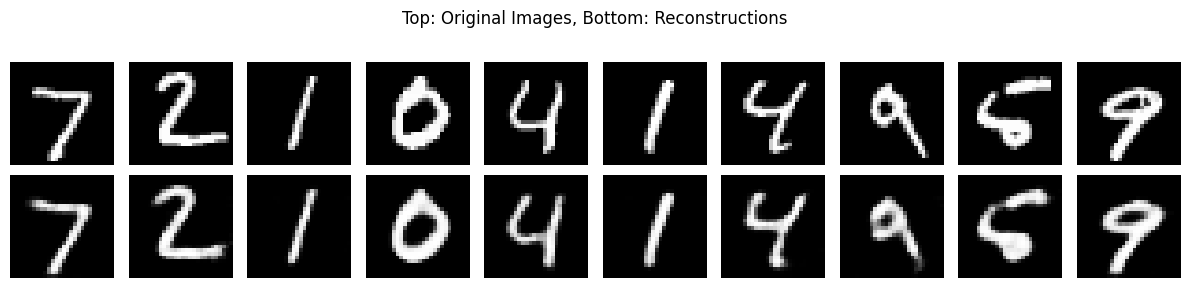

In [ ]:
model.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)
    outputs = model(imgs)

    # Plot original and reconstructed images
    imgs = imgs.cpu().numpy()
    outputs = outputs.cpu().numpy()

    fig, axes = plt.subplots(2, 10, figsize=(12, 3))
    for i in range(10):
        axes[0, i].imshow(imgs[i][0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(outputs[i][0], cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle("Top: Original Images, Bottom: Reconstructions")
    plt.tight_layout()
    plt.show()

#### 4.5 Define 7-Segment Encoding and MLP Classifier

In [ ]:
digit_to_segment = {
    0: [1, 1, 1, 0, 1, 1, 1],
    1: [0, 0, 1, 0, 0, 1, 0],
    2: [1, 0, 1, 1, 1, 0, 1],
    3: [1, 0, 1, 1, 0, 1, 1],
    4: [0, 1, 1, 1, 0, 1, 0],
    5: [1, 1, 0, 1, 0, 1, 1],
    6: [1, 1, 0, 1, 1, 1, 1],
    7: [1, 0, 1, 0, 0, 1, 0],
    8: [1, 1, 1, 1, 1, 1, 1],
    9: [1, 1, 1, 1, 0, 1, 1],
}
segment_labels = torch.tensor([digit_to_segment[i] for i in range(10)], dtype=torch.float32)

#### 4.6 Defining a simple Multi-Layer Perceptron (MLP) model using PyTorch
- To classify the latent representations from the autoencoder into a 7-segment encoding.

In [ ]:
class SegmentMLP(nn.Module):
    def __init__(self, input_dim=32, hidden_dim=64):
        super(SegmentMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 7),
            nn.Sigmoid()  # Outputs between 0 and 1 for each segment
        )

    def forward(self, x):
        return self.model(x)

#### 4.7 Training MLP and Generate Confusion Matrix

In [ ]:
# Prepare training data: get latent vectors and segment labels
def prepare_latent_features(model, data_loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for imgs, digits in data_loader:
            imgs = imgs.to(device)
            latent = model.encode(imgs)
            for i in range(len(digits)):
                features.append(latent[i].cpu().numpy())
                labels.append(digit_to_segment[digits[i].item()])
    return torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

train_features, train_labels = prepare_latent_features(model, train_loader)
test_features, test_labels_raw = prepare_latent_features(model, test_loader)

# Train the MLP
mlp = SegmentMLP(input_dim=32).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(num_epochs):
    mlp.train()
    inputs = train_features.to(device)
    targets = train_labels.to(device)
    outputs = mlp(inputs)
    loss = criterion(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

<ipython-input-100-166010118>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)


Epoch [1/10], Loss: 1.8830
Epoch [2/10], Loss: 1.6715
Epoch [3/10], Loss: 1.4831
Epoch [4/10], Loss: 1.3199
Epoch [5/10], Loss: 1.1817
Epoch [6/10], Loss: 1.0669
Epoch [7/10], Loss: 0.9730
Epoch [8/10], Loss: 0.8974
Epoch [9/10], Loss: 0.8378
Epoch [10/10], Loss: 0.7920


#### 4.8 Predicting and generating confusion matrix

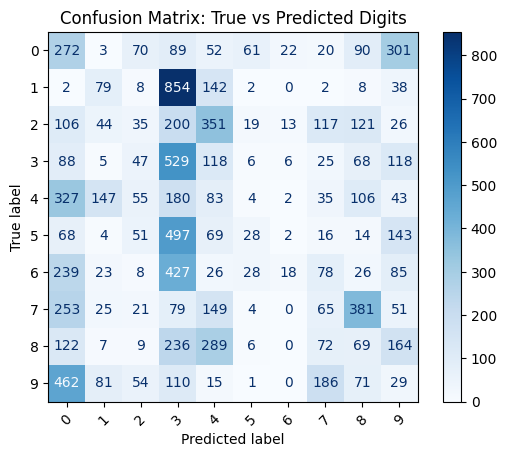

In [ ]:
mlp.eval()
with torch.no_grad():
    preds = mlp(test_features.to(device)).cpu().numpy()

# Match prediction to closest digit using Hamming distance
def predict_digit(pred):
    min_dist = float('inf')
    best_digit = -1
    for digit, seg in digit_to_segment.items():
        dist = np.sum(np.round(pred) != seg)
        if dist < min_dist:
            min_dist = dist
            best_digit = digit
    return best_digit

y_pred = [predict_digit(p) for p in preds]
y_true = []

# Rebuild true digit labels from test_loader (since we only used segment labels before)
for _, digits in test_loader:
    y_true.extend(digits.numpy())

# Truncate to match prediction length if needed
y_true = y_true[:len(y_pred)]

# Generate and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: True vs Predicted Digits")
plt.show()

- Digit '1' was classified most accurately (854 correct) due to its distinctive 2-segment pattern.
- Digits '3', '4', and '9' showed high recognition accuracy with minimal confusion.
- Digit '8' was the most frequently confused digit — misclassified as many others, likely because its 7-segment encoding activates all segments.
- Digits '2', '3', '5', and '6' showed overlapping misclassifications due to similar segment combinations.
- Digit '0' was often misclassified as '8' or '9' because of their similar encodings.

Overall, the model learned meaningful distinctions from 7-segment encodings despite their limited expressiveness.
Confusions align with expected segment-level similarities and confirm the effectiveness of using AE-extracted features with a segment-based MLP.

